In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random
import cv2
from tqdm import tqdm

import torch
import torchvision.transforms.functional as F

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/ML'

In [ ]:
# labels = [{'name':'Apple', 'id':1}, {'name':'Banana', 'id':2}, {'name':'Orange', 'id':3}]

# with open(ROOT_DIR + '/Data/label_map.pbtxt', 'w') as f:
#     for label in labels:
#         f.write('item { \n')
#         f.write('\tname:\'{}\'\n'.format(label['name']))
#         f.write('\tid:{}\n'.format(label['id']))
#         f.write('}\n')

In [ ]:
!python {ROOT_DIR + '/Utils/xml_to_csv.py'} 'xml' \
        {ROOT_DIR + '/Data/train/'}  \
        {ROOT_DIR + '/Data/train.csv'} 


# !python {ROOT_DIR + '/Utils/xml_to_csv.py'} 'xml' \
#         {ROOT_DIR + '/Data/test/'}  \
#         {ROOT_DIR + '/Data/test.csv'} 


100% 240/240 [02:06<00:00,  1.89it/s]


In [ ]:

train_csv = pd.read_csv(str(ROOT_DIR + '/Data/train.csv'))
train_csv.head(3)

# test_csv = pd.read_csv(str(ROOT_DIR + '/Data/test.csv'))
# test_csv.head(3)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,banana_28.jpg,1008,1008,banana,41,260,943,738
1,banana_50.jpg,620,413,banana,373,104,514,345
2,banana_50.jpg,620,413,banana,298,93,382,354


In [ ]:
def rmv_extension(f=''):
  f = f.split('.')
  f = ".".join(f[:-1])
  return f

def get_extension(f=''):
  f = f.split('.')
  return f[-1]

def box_cord( csv_file, image_name ):
  bboxs = csv_file[csv_file.filename == image_name][['xmin','ymin','xmax','ymax']]
  return torch.from_numpy(bboxs.to_numpy())


In [ ]:
def draw_boxs_byname( img_names, test=False):

  loc = 'train' if not test else 'test'
  file = train_csv if not test else test_csv
  img = plt.imread( f'{ROOT_DIR}/Data/{loc}/{img_names}')
  for r in box_cord( file , img_names ):
    img = cv2.rectangle(img,(r[0],r[1]),(r[2],r[3]),color=(0,255,0),thickness=2)

  return img

def draw_boxs_byimg( img, boxs):
  for r in boxs:
    img = cv2.rectangle(img,(r[0],r[1]),(r[2],r[3]),color=(0,255,0),thickness=2)

  return img

In [ ]:

def Adjust_brightness(image, boxes):
    return F.adjust_brightness(image, np.random.uniform(1,2)), boxes

def Adjust_contrast(image, boxes):
    return F.adjust_contrast(image, np.random.uniform(1,2)), boxes

def Adjust_saturation(image, boxes):
    return F.adjust_saturation(image,  np.random.uniform(1,2)), boxes

def lighting_noise(image, boxes):
    new_image = image
    perms = ((0, 1, 2), (0, 2, 1), (1, 0, 2), 
             (1, 2, 0), (2, 0, 1), (2, 1, 0))
    swap = perms[random.randint(0, len(perms)- 1)]
    new_image = F.to_tensor(new_image)
    new_image = new_image[swap, :, :]
    new_image = F.to_pil_image(new_image)
    return new_image, boxes


def hflip(image, boxes):

    new_image = F.hflip(image)    
    #flip boxes     
    new_boxes = boxes.clone()
    new_boxes[:, 0] = image.width - boxes[:, 0]
    new_boxes[:, 2] = image.width - boxes[:, 2]
    return new_image, new_boxes


def vflip(image, boxes):

    new_image = F.vflip(image)    
    #flip boxes     
    new_boxes = boxes.clone()
    new_boxes[:, 1] = image.height - boxes[:, 1]
    new_boxes[:, 3] = image.height - boxes[:, 3]
    return new_image, new_boxes


def rotate(image, boxes, angle=np.random.randint(1,11)):
    '''
        Rotate image and bounding box
        image: A Pil image (w, h)
        boxes: A tensors of dimensions (#objects, 4)
        
        Out: rotated image (w, h), rotated boxes
    '''
    new_image = image.copy()
    new_boxes = boxes.clone()
    
    #Rotate image, expand = True
    w = image.width
    h = image.height
    cx = w/2
    cy = h/2
    new_image = new_image.rotate(angle, expand= True)
    angle = np.radians(angle)
    alpha = np.cos(angle)
    beta = np.sin(angle)
    #Get affine matrix
    AffineMatrix = torch.tensor([[alpha, beta, (1-alpha)*cx - beta*cy],
                                 [-beta, alpha, beta*cx + (1-alpha)*cy]])
    
    #Rotation boxes
    box_width = (boxes[:,2] - boxes[:,0]).reshape(-1,1)
    box_height = (boxes[:,3] - boxes[:,1]).reshape(-1,1)
    
    #Get corners for boxes
    x1 = boxes[:,0].reshape(-1,1)
    y1 = boxes[:,1].reshape(-1,1)
    
    x2 = x1 + box_width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + box_height
    
    x4 = boxes[:,2].reshape(-1,1)
    y4 = boxes[:,3].reshape(-1,1)
    
    corners = torch.stack((x1,y1,x2,y2,x3,y3,x4,y4), dim= 1)
    # corners.reshape(8, 8)    #Tensors of dimensions (#objects, 8)
    corners = corners.reshape(-1,2) #Tensors of dimension (4* #objects, 2)
    corners = torch.cat((corners, torch.ones(corners.shape[0], 1).long()), dim= 1) #(Tensors of dimension (4* #objects, 3))
    
    cos = np.abs(AffineMatrix[0, 0])
    sin = np.abs(AffineMatrix[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    AffineMatrix[0, 2] += (nW / 2) - cx
    AffineMatrix[1, 2] += (nH / 2) - cy
    
    #Apply affine transform
    rotate_corners = torch.mm(AffineMatrix , corners.t().double()).t()
    rotate_corners = rotate_corners.reshape(-1,8)
    
    x_corners = rotate_corners[:,[0,2,4,6]]
    y_corners = rotate_corners[:,[1,3,5,7]]
    
    #Get (x_min, y_min, x_max, y_max)
    x_min, _ = torch.min(x_corners, dim= 1)
    x_min = x_min.reshape(-1, 1)
    y_min, _ = torch.min(y_corners, dim= 1)
    y_min = y_min.reshape(-1, 1)
    x_max, _ = torch.max(x_corners, dim= 1)
    x_max = x_max.reshape(-1, 1)
    y_max, _ = torch.max(y_corners, dim= 1)
    y_max = y_max.reshape(-1, 1)
    
    new_boxes = torch.cat((x_min, y_min, x_max, y_max), dim= 1)
    
    scale_x = new_image.width / w
    scale_y = new_image.height / h
    
    #Resize new image to (w, h)
    new_image = new_image.resize((w, h))
    
    #Resize boxes
    new_boxes /= torch.Tensor([scale_x, scale_y, scale_x, scale_y])
    new_boxes[:, 0] = torch.clamp(new_boxes[:, 0], 0, w)
    new_boxes[:, 1] = torch.clamp(new_boxes[:, 1], 0, h)
    new_boxes[:, 2] = torch.clamp(new_boxes[:, 2], 0, w)
    new_boxes[:, 3] = torch.clamp(new_boxes[:, 3], 0, h)

    return new_image, new_boxes


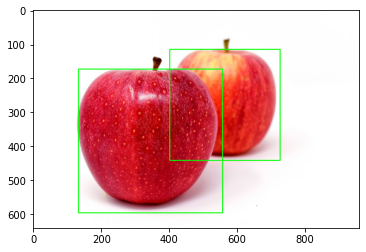

In [ ]:
img_name = 'apple_48.jpg'
img = plt.imread(f'{ROOT_DIR}/Data/train/{img_name}')
plt.imshow(draw_boxs_byimg(img,box_cord(train_csv,img_name)))

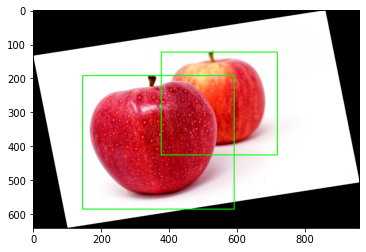

In [ ]:
img = Image.open(f'{ROOT_DIR}/Data/train/{img_name}')
box = box_cord(train_csv,img_name)
img, box = rotate(img, box)

plt.imshow(draw_boxs_byimg(np.asarray(img),box))

In [ ]:
print(len(glob.glob(ROOT_DIR+'/Data/train/*.jpg')),train_csv.shape)
train_csv.tail(3)

240 (480, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
477,apple_26.jpg,350,241,apple,61,22,217,174
478,apple_27.jpg,700,350,apple,51,3,414,350
479,apple_27.jpg,700,350,apple,270,43,657,350


In [ ]:
# Creating more annotated images to imporve Datasets & trainig


for f in tqdm(os.listdir(ROOT_DIR+'/Data/train')):
  ext = get_extension(f)
  if ext in ['jpg','jpeg','png']:
    img = Image.open(ROOT_DIR+'/Data/train/'+f)



    # Few jpg files were currupt (they were png but their extention was jpg)
    # so this part is to delete those fles and save them as jpg
    os.remove(ROOT_DIR+'/Data/train/'+f)
    img = img.convert('RGB')
    img.save(f'{ROOT_DIR}/Data/train/{f}')
    


    box = box_cord(train_csv,f)

    # Appling few random augmentations to images & boxes

    if random.getrandbits(1):
      img, box = Adjust_brightness( img, box )
    if random.getrandbits(1):
      img, box = Adjust_contrast( img, box )
    if random.getrandbits(1):
      img, box = Adjust_saturation( img, box )
    
    # This annotation I'm commenting so that we can also take advantage of colors,
    # this annotation could have been usefull in case we had large data set    

    # if random.getrandbits(1):
    #   img, box = lighting_noise( img, box )

    if random.getrandbits(1):
      img, box = hflip( img, box )
    if random.getrandbits(1):
      img, box = vflip( img, box )
    if random.getrandbits(1):
      img, box = rotate( img, box )
    
    new_name = rmv_extension(f) + '_n.' + ext
    d = dict(train_csv[train_csv.filename == f].iloc[0])
    for i,b in enumerate(box):
      d['filename'] = new_name
      d['xmin'] = int(box[i][0] if box[i][0] < box[i][2] else box[i][2] )
      d['ymin'] = int(box[i][1] if box[i][1] < box[i][3] else box[i][3] )
      d['xmax'] = int(box[i][2] if box[i][0] < box[i][2] else box[i][0] )
      d['ymax'] = int(box[i][3] if box[i][1] < box[i][3] else box[i][1] )

    train_csv = train_csv.append(d,ignore_index=True)
    img.save(f'{ROOT_DIR}/Data/train/{new_name}')




100%|██████████| 480/480 [01:37<00:00,  4.92it/s]


In [ ]:
train_csv.tail(3)

,filename,width,height,class,xmin,ymin,xmax,ymax
717,orange_31_n.jpg,1300,1177,orange,702,530,1249,1045
718,orange_72_n.jpg,416,416,orange,37,51,368,379
719,orange_60_n.jpg,1824,1951,orange,241,191,1633,1590


In [ ]:
train_csv.to_csv(f'{ROOT_DIR}/Data/train_n.csv')